In [25]:
# Importar librerias standard de Qiskit
from qiskit import *
from qiskit.quantum_info import Operator
from qiskit.circuit.library import *
from qiskit.visualization import *
from qiskit_ibm_runtime import *
from qiskit_aer import *

import numpy as np
import galois

service = QiskitRuntimeService(channel="local")

In [70]:
def ket_reg(n, x):
    if x < 0 or x > 2**n-1:
        return(-1)
    output = [[0] for i in range(x)]+[[1]]+ [[0] for i in range(2**n-x-1)]
    return(np.matrix(output))
def bra_reg(n,x):
    return(ket_reg(n,x).H)

def Oracle(n, f):
    dim = 2**(2*n)  #n qubits entrada y n qubits salida
    unitary = np.zeros((dim, dim), dtype=complex)
    
    for x in range(2**n):
        for y in range(2**n):
            bra_in  = np.kron(bra_reg(n, y), bra_reg(n, x)) #!!LITTLE-ENDIAN!! (x son las posiciones mas altas e y las mas bajas)
            ket_out = np.kron(ket_reg(n, y ^ f(x)), ket_reg(n, x)) #!!LITTLE-ENDIAN!! (x son las posiciones mas altas e y las mas bajas)

            unitary += ket_out @ bra_in

    return UnitaryGate(unitary, label='U_f')

In [71]:
def Simon(s: str):
    n = len(s)
    per = np.random.permutation(n)
    def f(x):
        out1 = min (x, x ^ int(s,2))
        out1 = f'{out1:0{n}b}'
        out2 = ""
        for i in range(n):
            out2 = out2 + out1[per[i]]
        return(int(out2,2))
    return f 

In [72]:
s = "001"
f = Simon(s)

for x in range(8):
    print(f"x={x:03b} -> f(x)={f(x):03b}")

x=000 -> f(x)=000
x=001 -> f(x)=000
x=010 -> f(x)=100
x=011 -> f(x)=100
x=100 -> f(x)=001
x=101 -> f(x)=001
x=110 -> f(x)=101
x=111 -> f(x)=101


In [73]:
for x in range(8):
    print(f"f({x})={f(x)}")

f(0)=0
f(1)=0
f(2)=4
f(3)=4
f(4)=1
f(5)=1
f(6)=5
f(7)=5


In [74]:
def Simon_circuit(function, n):
    x = QuantumRegister(n, 'x')
    y = QuantumRegister(n, 'y')
    measure = ClassicalRegister(n,'measure')
    
    qc = QuantumCircuit(x,y,measure)

    qc.h(x)

    qc.barrier()
    
    qc.append(Oracle(n, function), list(x) + list(y))

    qc.barrier()
    
    qc.h(x)

    qc.measure(x, measure)
    
    return(qc)
    

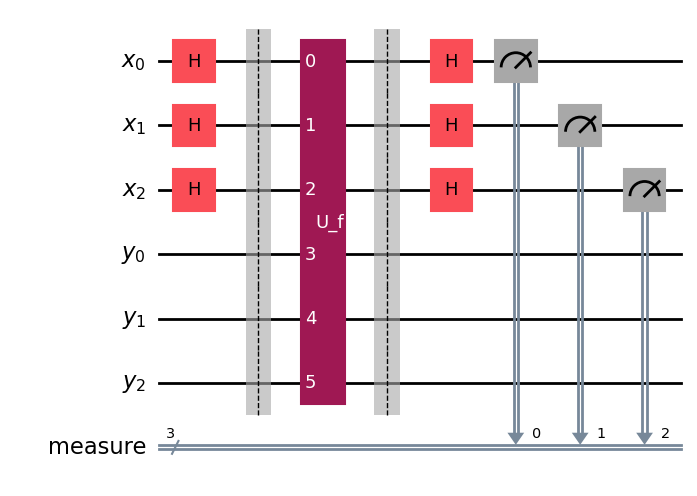

In [75]:
s = "110"
n = len(s)
qc = Simon_circuit(Simon(s), n);

qc.draw('mpl')

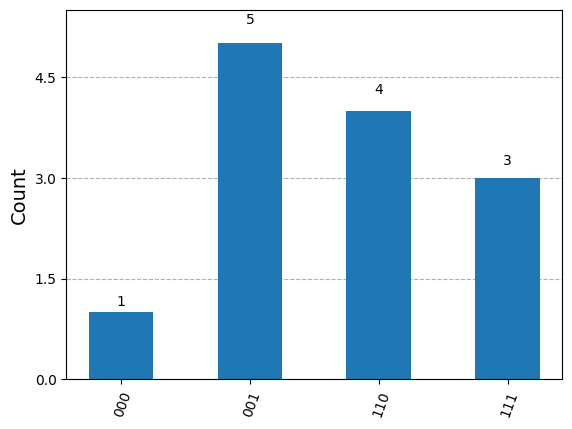

In [76]:
# Transpile for simulator
simulator = AerSimulator()
circuit = transpile(qc, simulator)

# Run and get counts
SHOTS = n + 10
result = simulator.run(circuit,shots=SHOTS, memory=True).result()
counts = result.get_counts()
plot_histogram(counts)

In [69]:
measurements = list(counts.keys())
matrix = np.array([list(bitstring) for bitstring in measurements]).astype(int)
null_space = galois.GF(2)(matrix).null_space()
display(null_space)


GF([[1, 1, 0]], order=2)